In [1]:
from ray.rllib.agents.ppo.ddppo import DDPPOTrainer
from Environments.Simple_Env import SimpleMarket
from ray.rllib.agents.ppo.ddppo import DEFAULT_CONFIG
import ray

In [2]:
path = '/home/miner/ray_results/DDPPO_SimpleMarket_2020-10-02_10-32-407mluh4uw/checkpoint_52/checkpoint-52'

In [3]:
try:
    ray.init(num_gpus = 4, num_cpus = 4)
except:
    ray.shutdown()
    ray.init(num_gpus = 4, num_cpus = 4)

2020-10-04 11:41:18,719	INFO resource_spec.py:231 -- Starting Ray with 4.3 GiB memory available for workers and up to 2.16 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-10-04 11:41:19,200	INFO services.py:1193 -- View the Ray dashboard at localhost:8265


In [4]:
trainer_config = DEFAULT_CONFIG.copy()
trainer_config['model']['use_lstm'] = False
trainer_config['model']['lstm_cell_size'] = 16
trainer_config['num_gpus'] = 0
trainer_config['num_gpus_per_worker'] = 4
trainer_config['num_envs_per_worker'] = 2
trainer_config['gamma'] = 0.99
trainer_config['entropy_coeff'] = 0.00
trainer_config['framework'] = 'torch'
trainer_config['num_workers'] = 1
trainer_config['horizon'] = 10000
trainer_config['rollout_fragment_length'] = 10000
trainer_config['model']['framestack'] = False
trainer_config['model']['fcnet_hiddens'] = [32, 32]
trainer_config['lr'] = 15e-05
trainer_config['env_config'] = {'last_states_num': None,
                               'action_mode' : 1,
                               'curiosity_reward': 0}

In [5]:
trainer = DDPPOTrainer(trainer_config, SimpleMarket)

2020-10-04 11:41:21,368	ERROR syncer.py:46 -- Log sync requires rsync to be installed.
2020-10-04 11:41:21,373	INFO trainer.py:632 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2020-10-04 11:41:33,934	INFO trainable.py:251 -- Trainable.setup took 12.565 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
(pid=5898) /home/miner/RL/lib/python3.7/site-packages/ray/rllib/utils/torch_ops.py:149: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
(pid=5898)  

In [6]:
trainer.load_checkpoint(path)

In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [8]:
env = SimpleMarket(env_config = {'action_mode': 1,
                               'last_states_num': None,
                               'version': 'long',
                               'curiosity_reward':0,}
                                , episode_length=10000, comission = 0.0025)
obs = env.reset()
done = False
cumulative_reward = 0
prices = []
assets = []
actions = []
states = [obs]
rewards = []
hidden = [torch.zeros(128),torch.zeros(128)]
infos = []
for i in range(9999):
    action, hidden, info = trainer.compute_action(obs, hidden)
    obs, reward, done, results = env.step(action)
    cumulative_reward += reward
    rewards.append(reward)
    actions.append(action)
    assets.append(env.last_assets)
    prices.append(env.current_price)
    states.append(obs)
    infos.append(info)
print("Cumulative reward you've received is: {}. Congratulations!".format(cumulative_reward))
print("Asset_Gain {}".format(assets[-1] -assets[0]))
print("Realtive to the market {}".format(((assets[-1]/assets[0])/(prices[-1]/prices[0]))- 1))
print('Percentage of capital {}'.format(assets[-1]/assets[0]))
print("Market Change {}".format((prices[-1]/prices[0])))

(pid=5898) [W ProcessGroupGloo.cpp:471] Warning: Unable to resolve hostname to a (local) address. Using the loopback address as fallback. Manually set the network interface to bind to with GLOO_SOCKET_IFNAME. (function operator())


Cumulative reward you've received is: 22379.92007613337. Congratulations!
Asset_Gain 114.43752511212483
Realtive to the market 0.07192943016694708
Percentage of capital 1.1144375251121248
Market Change 1.0396556841792817


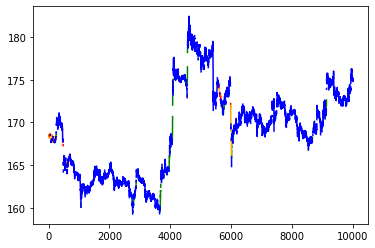

In [9]:
sell100 = np.ma.masked_where(np.array(actions) != 6, prices)
buy10 = np.ma.masked_where(np.array(actions) != 1, prices)
sell10 = np.ma.masked_where(np.array(actions) != 4, prices)
buy50 = np.ma.masked_where(np.array(actions) != 2, prices)
sell50 = np.ma.masked_where(np.array(actions) != 5, prices)
buy100 = np.ma.masked_where(np.array(actions) != 3, prices)
hold = np.ma.masked_where(np.array(actions) != 0, prices)
plt.plot(sell10, c = 'yellow')

plt.plot(buy10, c = 'turquoise')
plt.plot(buy50, c = 'lime')
plt.plot(buy100, c = 'green')
plt.plot(sell50, c = 'orange')
plt.plot(sell100, c = 'red')
plt.plot(hold, c = 'blue')

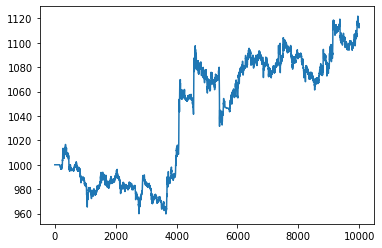

In [10]:
plt.plot(assets)

In [11]:
env = SimpleMarket(env_config = {'last_states_num': None, 'action_mode': 1, 'version': 'long', 'curiosity_reward':0})
obs = env.test()

done = False
cumulative_reward = 0
prices = []
assets = []
actions = []
states = [obs]
rewards = []
hidden = [torch.zeros(512),torch.zeros(512)]
infos = []
for i in range(50000):
    action, hidden, info = trainer.compute_action(obs, hidden)
    obs, reward, done, results = env.step(action)
    cumulative_reward += reward
    rewards.append(reward)
    actions.append(action)
    assets.append(env.last_assets)
    prices.append(env.current_price)
    states.append(obs)
    infos.append(info)
print("Cumulative reward you've received is: {}. Congratulations!".format(cumulative_reward))
print("Asset_Gain {}".format(assets[-1] -assets[0]))
print("Realtive to the market {}".format(((assets[-1]/assets[0])/(prices[-1]/prices[0]))- 1))
print('Percentage of capital {}'.format(assets[-1]/assets[0]))
print("Market Change {}".format((prices[-1]/prices[0])))

Cumulative reward you've received is: 70591.71118005957. Congratulations!
Asset_Gain 262.0134893320344
Realtive to the market 0.8589077469776605
Percentage of capital 1.2620134893320345
Market Change 0.67890054866031


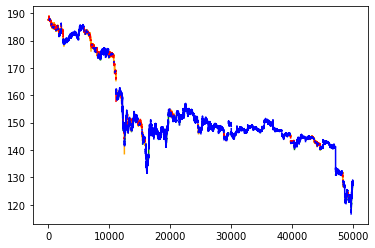

In [12]:
sell100 = np.ma.masked_where(np.array(actions) != 6, prices)
buy10 = np.ma.masked_where(np.array(actions) != 1, prices)
sell10 = np.ma.masked_where(np.array(actions) != 4, prices)
buy50 = np.ma.masked_where(np.array(actions) != 2, prices)
sell50 = np.ma.masked_where(np.array(actions) != 5, prices)
buy100 = np.ma.masked_where(np.array(actions) != 3, prices)
hold = np.ma.masked_where(np.array(actions) != 0, prices)

plt.plot(buy10, c = 'turquoise')
plt.plot(buy50, c = 'lime')
plt.plot(buy100, c = 'green')
plt.plot(sell10, c = 'yellow')
plt.plot(sell50, c = 'orange')
plt.plot(sell100, c = 'red')
plt.plot(hold, c = 'blue')

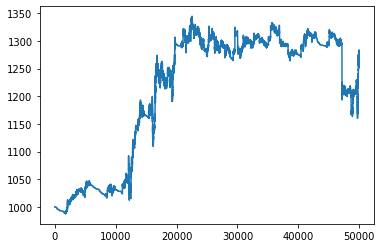

In [13]:
plt.plot(assets)